# **Cassava Leaf Disease Classification**

This project is on kaggle competition Cassava Leaf Disease Classification. Identify the type of disease present in Cassava Leaf image. This competition, has a dataset of 21,367 labeled images collected during a regular survey in Uganda.The task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. So that, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.

This is a Computer Vision problem where we have to try differernt CV models.Submissions are evaluated based on their categorization accuracy.

# **Data Set**

**Files:**

[train/test]_images : the image files. Roughly 15,000 images in the test set.

[train/test]_tfrecords : the image files in tfrecord format.

label_num_to_disease_map.json : The mapping between each disease code and the real disease name.

sample_submission.csv : A properly formatted sample submission, given the disclosed test set content.


**train.csv:**

image_id : the image file name.

label : the ID code for the disease.

# **1. Reading Data**

## **1.1 Loading Data**

In [ ]:
#checking GPU
import nvidia_smi
!nvidia-smi

Mon May 16 13:58:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install albumentations==1.1.0

     |████████████████████████████████| 102 kB 10.9 MB/s 
     |████████████████████████████████| 47.8 MB 1.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
pip install opencv-python==4.5.4.60

     |████████████████████████████████| 60.3 MB 1.3 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
pip install timm

     |████████████████████████████████| 431 kB 8.6 MB/s 


### **1.1.1 CASSAVA CFG**

In [ ]:
class CASSAVA:
  error = False
  freq_print = 100
  cpu = 4
  cv_model = 'resnext50_32x4d'
  image_size = 512
  learning_rate_sch='CosineAnnealingWarmRestarts'     
  no_epc = 10
  cosine_annealing = 10 # CosineAnnealingWarmRestarts
  learning_rate = 1e-4
  min_learning_rate = 1e-6
  data_batch = 16
  wd = 1e-6
  maximum_gradient = 1000
  random_seed = 42
  number_of_labels = 5
  label_column='label'
  kfold_no = 5
  kfold = [0, 1, 2, 3, 4]
  tr=True
  inf=False

### **1.1.2 Libraries and Modules**

In [ ]:
import os
import math
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sys
sys.path.append('./pytorch-image-models-master')
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import scipy as sp
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
from tqdm.auto import tqdm
from functools import partial
import cv2
from PIL import Image
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
import timm
from google.colab import drive
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
cuda = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
cuda

device(type='cuda')

In [ ]:
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/cassava")

Mounted at /content/gdrive


### **1.1.4 Directory Settings**

In [ ]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
  os.makedirs(OUTPUT_DIR)

TRAIN_PATH = 'input/train_images'
TEST_PATH = 'input/test_images'

### **1.1.5 Cassava Train and Test Data**

In [ ]:
cassava_data = pd.read_csv('train.csv')
cassava_test = pd.read_csv('sample_submission.csv')
cassava_to_disease_id = pd.read_json('label_num_to_disease_map.json', 
                         orient='index')

In [ ]:
if CASSAVA.error:
  CASSAVA.no_epc = 1
  cassava_data = cassava_data.sample(n=1000, random_state=CASSAVA.randoom_seed).reset_index(drop=True)

In [ ]:
cassava_data.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [ ]:
cassava_test.head()

image_id  label
0  2216849948.jpg      4

In [ ]:
cassava_to_disease_id.head()

0
0       Cassava Bacterial Blight (CBB)
1  Cassava Brown Streak Disease (CBSD)
2           Cassava Green Mottle (CGM)
3         Cassava Mosaic Disease (CMD)
4                              Healthy

# **2. EDA**

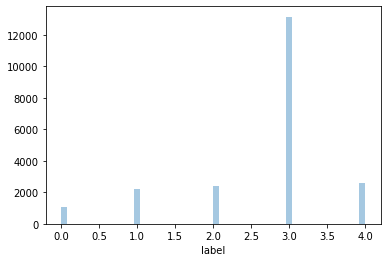

In [ ]:
sns.distplot(cassava_data['label'], kde=False)

In [ ]:
cassava_data['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [ ]:
np.round((cassava_data['label'].value_counts()/len(cassava_data['label']))*100, 2)

3    61.49
4    12.04
2    11.15
1    10.23
0     5.08
Name: label, dtype: float64

## **2.0 Disease 0/CBB Leaves**

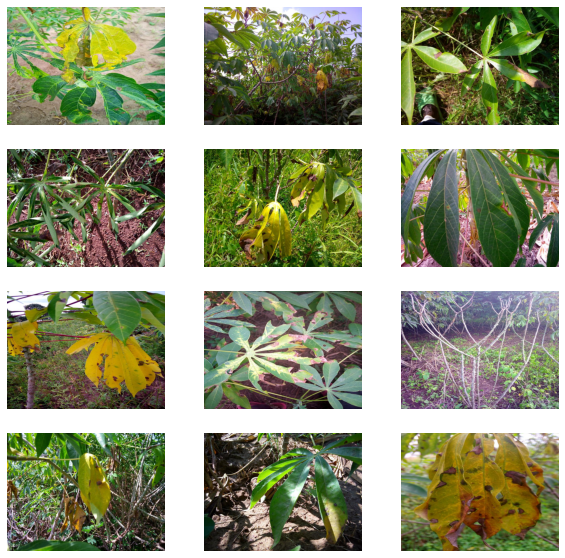

In [ ]:
cassava_sample = cassava_data[cassava_data.label == 0].sample(12)
plt.figure(figsize=(10,10))
for index, (id, label) in enumerate(zip(cassava_sample.image_id, cassava_sample.label)):
  plt.subplot(4, 3, index + 1)
  cassava_img = cv2.imread(os.path.join(TRAIN_PATH, id))
  cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
  plt.imshow(cassava_img)
  plt.axis("off")

## **2.1 Disease 1/CBSD Leaves**

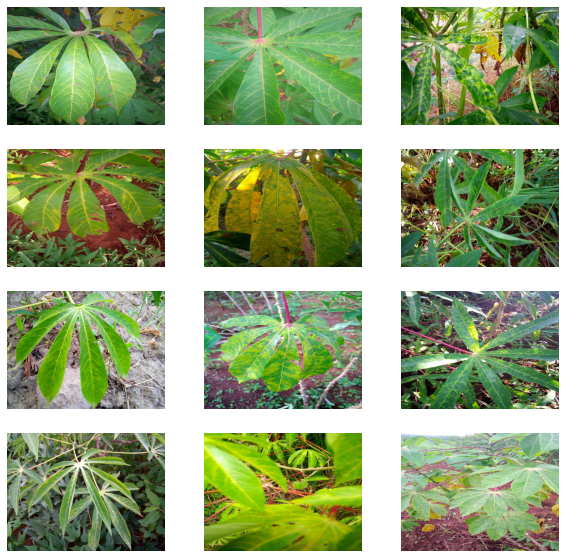

In [ ]:
cassava_sample = cassava_data[cassava_data.label == 1].sample(12)
plt.figure(figsize=(10,10))
for index, (id, label) in enumerate(zip(cassava_sample.image_id, cassava_sample.label)):
  plt.subplot(4, 3, index + 1)
  cassava_img = cv2.imread(os.path.join(TRAIN_PATH, id))
  cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
  plt.imshow(cassava_img)
  plt.axis("off")

## **2.2 Disease 2/CGM Leaves**

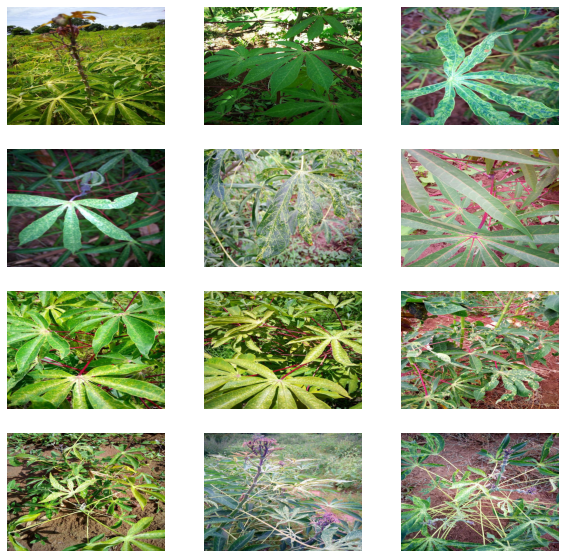

In [ ]:
cassava_sample = cassava_data[cassava_data.label == 2].sample(12)
plt.figure(figsize=(10,10))
for index, (id, label) in enumerate(zip(cassava_sample.image_id, cassava_sample.label)):
  plt.subplot(4, 3, index + 1)
  cassava_img = cv2.imread(os.path.join(TRAIN_PATH, id))
  cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
  plt.imshow(cassava_img)
  plt.axis("off")

## **2.3 Disease 3/CMD Leaves**

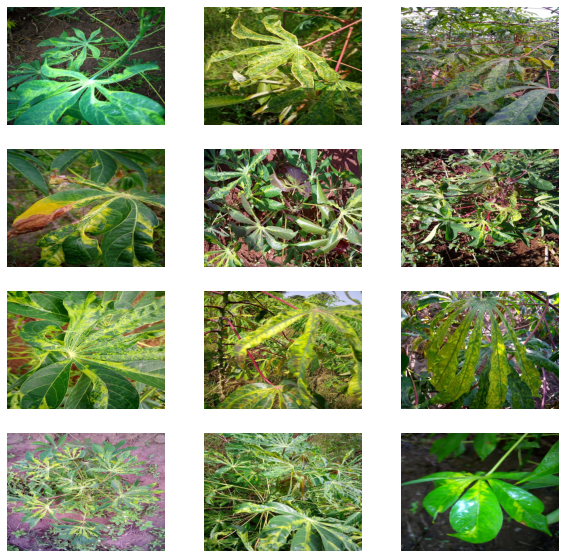

In [ ]:
cassava_sample = cassava_data[cassava_data.label == 3].sample(12)
plt.figure(figsize=(10,10))
for index, (id, label) in enumerate(zip(cassava_sample.image_id, cassava_sample.label)):
  plt.subplot(4, 3, index + 1)
  cassava_img = cv2.imread(os.path.join(TRAIN_PATH, id))
  cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
  plt.imshow(cassava_img)
  plt.axis("off")

## **2.4 Healthy Leaves**

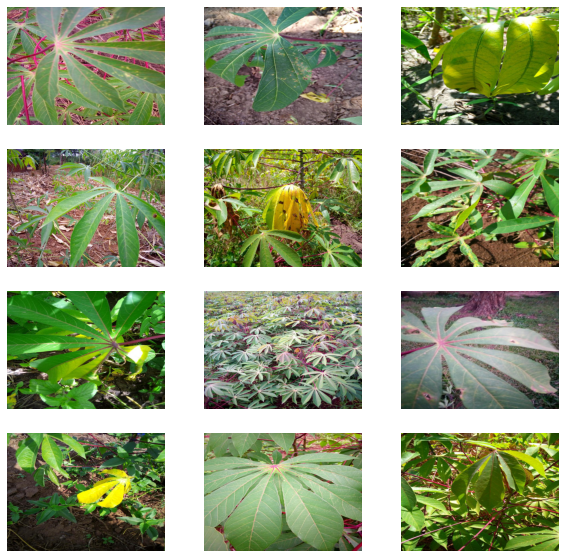

In [ ]:
cassava_sample = cassava_data[cassava_data.label == 4].sample(12)
plt.figure(figsize=(10,10))
for index, (id, label) in enumerate(zip(cassava_sample.image_id, cassava_sample.label)):
  plt.subplot(4, 3, index + 1)
  cassava_img = cv2.imread(os.path.join(TRAIN_PATH, id))
  cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
  plt.imshow(cassava_img)
  plt.axis("off")

# **3. Cross Validation Split and Utility functions**

In [ ]:
cassava_data_kfolds = cassava_data.copy()
kfolds = StratifiedKFold(n_splits=CASSAVA.kfold_no, shuffle=True, random_state=CASSAVA.random_seed)
for k_number, (tr_idx, val_idx) in enumerate(kfolds.split(cassava_data_kfolds, cassava_data_kfolds[CASSAVA.label_column])):
    cassava_data_kfolds.loc[val_idx, 'fold'] = int(k_number)
cassava_data_kfolds['fold'] = cassava_data_kfolds['fold'].astype(int)
print(cassava_data_kfolds.groupby(['fold', CASSAVA.label_column]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


In [ ]:
cassava_data_kfolds

image_id  label  fold
0      1000015157.jpg      0     3
1      1000201771.jpg      3     2
2       100042118.jpg      1     2
3      1000723321.jpg      1     1
4      1000812911.jpg      3     2
...               ...    ...   ...
21392   999068805.jpg      3     1
21393   999329392.jpg      3     0
21394   999474432.jpg      1     1
21395   999616605.jpg      4     2
21396   999998473.jpg      4     4

[21397 rows x 3 columns]

In [ ]:
def cassava_scr(label_true, label_pred):
  return accuracy_score(label_true, label_pred)


@contextmanager
def timer(name):
  start_time = time.time()
  CASSAVA_LOG.info(f'[{name}] start')
  yield
  CASSAVA_LOG.info(f'[{name}] done in {time.time() - start_time:.0f} s.')


def cassava_init_log(file=OUTPUT_DIR+'cassava_log.log'):
  from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
  logs = getLogger(__name__)
  logs.setLevel(INFO)
  stream = StreamHandler()
  stream.setFormatter(Formatter("%(message)s"))
  files = FileHandler(filename=file)
  files.setFormatter(Formatter("%(message)s"))
  logs.addHandler(stream)
  logs.addHandler(files)
  return logs

CASSAVA_LOG = cassava_init_log()


def rseed(rseed=42):
  random.seed(rseed)
  os.environ['PYTHONHASHSEED'] = str(rseed)
  np.random.seed(rseed)
  torch.manual_seed(rseed)
  torch.cuda.manual_seed(rseed)
  torch.backends.cudnn.deterministic = True

rseed(CASSAVA.random_seed)

# **4. Cassava Train and Test Datasets Classes**

In [ ]:
class Dataset_Train_Cassava(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.image_id = data['image_id'].values
    self.disease_no = data['label'].values
    self.transform = transform
        
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    image_id = self.image_id[index]
    image_id_path = f'{TRAIN_PATH}/{image_id}'
    cassava_img = cv2.imread(image_id_path)
    cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
        
        
    if self.transform:
      cassava_transform = self.transform(image=cassava_img)
      cassava_img = cassava_transform['image']
    disease_no = torch.tensor(self.disease_no[index]).long()
    return cassava_img, disease_no
    

class Dataset_Test_Cassava(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.image_id = data['image_id'].values
    self.transform = transform
        
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    image_id = self.image_id[index]
    image_id_path = f'{TEST_PATH}/{image_id}'
    cassava_img = cv2.imread(image_id_path)
    cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
        
    if self.transform:
      cassava_img = cassava_img.astype(np.float32)
      cassava_transform = self.transform(image=cassava_img)
      cassava_img = cassava_transform['image']
    return cassava_img

In [ ]:
cassava_train = Dataset_Train_Cassava(cassava_data, transform=None)
for index in range(10):
  cassava_img, disease_no = cassava_train[index]
  plt.imshow(cassava_img)
  plt.title(f'disease_no: {disease_no}')
  plt.show() 

# **5. Cassava Augmentation Function**

In [ ]:
def cassava_augmentation(*, df):
    
    if df == 'train':
        return Compose([
        RandomResizedCrop(CASSAVA.image_size, CASSAVA.image_size),
        OneOf([RandomBrightness(limit=(0.1), p=0.5), RandomContrast(limit=(0.1), p=0.5)], p=1,),
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3),], p=0.5,),
        VerticalFlip(p=0.5),
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=20,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_REFLECT_101,
            p=1,
        ),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        ToTensorV2(),
        ])

    elif df == 'valid':
        return Compose([
            Resize(CASSAVA.image_size, CASSAVA.image_size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

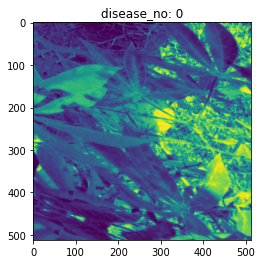

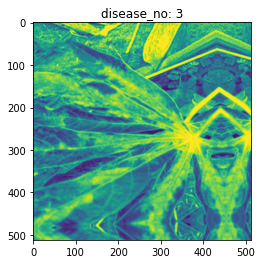

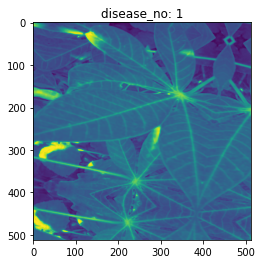

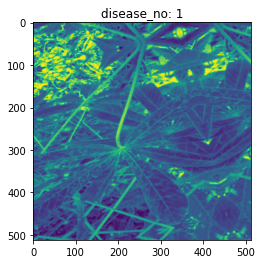

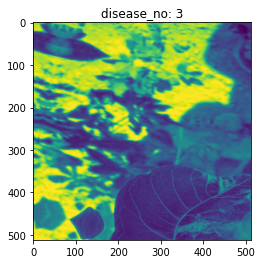

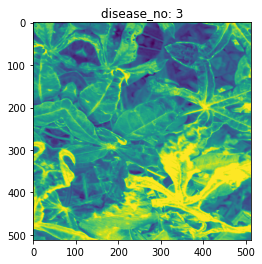

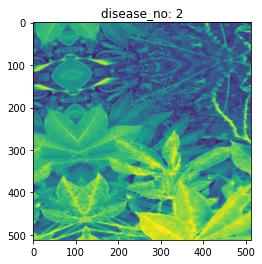

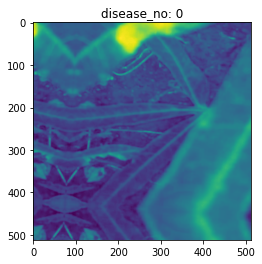

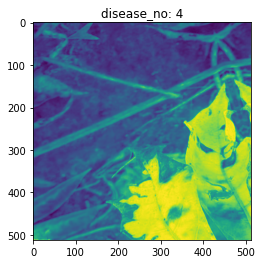

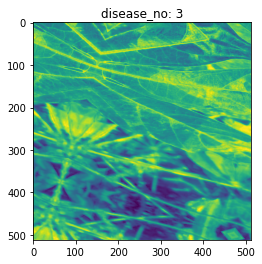

In [ ]:
cassava_train = Dataset_Train_Cassava(cassava_data, transform=cassava_augmentation(df='train'))

for index in range(10):
    cassava_img, disease_no = cassava_train[index]
    plt.imshow(cassava_img[0])
    plt.title(f'disease_no: {disease_no}')
    plt.show() 

# **6. Cassava ResNext50 Model**

In [ ]:
class Cassava_ResNext50(nn.Module):
  def __init__(self, resnext50='resnext50_32x4d', pretrained=False):
    super().__init__()
    self.resnext50 = timm.create_model(resnext50, pretrained=pretrained)
    resnext50_in_features = self.resnext50.fc.in_features
    self.resnext50.fc = nn.Linear(resnext50_in_features, CASSAVA.number_of_labels)

  def forward(self, input):
    input = self.resnext50(input)
    return input

In [ ]:
resnext50 = Cassava_ResNext50(resnext50=CASSAVA.cv_model, pretrained=False)
resnext50_train = Dataset_Train_Cassava(cassava_data, transform=cassava_augmentation(df='train'))
resnext50_loader = DataLoader(resnext50_train, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for img, disease_no in resnext50_loader:
  resnext50_img = resnext50(img)
  print(resnext50_img.shape)
  print(resnext50_img)
  break

torch.Size([4, 5])
tensor([[ 0.1146,  0.0962,  0.0679,  0.5306,  0.1654],
        [ 0.0780,  0.0746,  0.0912,  0.4903, -0.0328],
        [ 0.1405,  0.0271, -0.0098,  0.3916, -0.0028],
        [ 0.2071,  0.0367,  0.1479,  0.4335,  0.0859]],
       grad_fn=<AddmmBackward0>)


# **7. Cassava Train and Test Support Functions**

In [ ]:
#Computes and stores the average and current value
class CassavaStats(object):
  def __init__(self):
    self.restart()

  def restart(self):
    self.value = 0
    self.average = 0
    self.total = 0
    self.number = 0

  def update(self, value, number=1):
    self.value = value
    self.total += value * number
    self.number += number
    self.average = self.total / self.number


def sec_to_min(sec):
  min = math.floor(sec / 60)
  sec -= min * 60
  return '%dm' %min 

def LapsedTime(begin, division):
    current = time.time()
    lapse = current - begin
    lapse_es = lapse / (division)
    lapse_rs = lapse_es - lapse
    return '%s (Left:%s)' % (sec_to_min(lapse), sec_to_min(lapse_rs))

In [ ]:
def resnext50_tr(cassava_tr_iterable, resnext50, resnext50_entropy_loss, resnext50_opt, resnext50_epoch, resnext50_sch, cuda):

  stats_batch = CassavaStats()
  stats_time = CassavaStats()
  stats_loss = CassavaStats()
  stats_scores = CassavaStats()

  # switch to train mode
  resnext50.train()
  begin = finish = time.time()
  count = 0

  for number, (cassava_img, disease_no) in enumerate(cassava_tr_iterable):

    #print("finish:",finish)
    #print("time.time():",time.time())
    cassava_img = cassava_img.to(cuda)
    disease_no = disease_no.to(cuda)
    batch_size = disease_no.size(0)
    disease_forecast = resnext50(cassava_img)
    cassava_entropy_loss = resnext50_entropy_loss(disease_forecast, disease_no)

    # record loss
    stats_loss.update(cassava_entropy_loss.item(), batch_size)
    cassava_entropy_loss.backward()
    gradient_clip = torch.nn.utils.clip_grad_norm_(resnext50.parameters(), CASSAVA.maximum_gradient)

    resnext50_opt.step()
    resnext50_opt.zero_grad()
    count += 1    

    if number % CASSAVA.freq_print == 0 or number == (len(cassava_tr_iterable)-1):
      time_elapsed = round((time.time() - finish)/60,2)
      stats_time.update(time_elapsed)
      finish = time.time() 
      print('Epoch:[{0}][{1}/{2}]  '
            'Time:{stats_time.value} min  '
            'Lapsed:{left:s}  '
            'Loss:{stats_loss.value:.3f}  '
            'Gradient:{gradient_clip:.3f}  '
            .format(
              resnext50_epoch+1, number, len(cassava_tr_iterable),
              stats_time=stats_time,
              left=LapsedTime(begin, float(number+1)/len(cassava_tr_iterable)),
              stats_loss=stats_loss, gradient_clip=gradient_clip,
              ))
  return stats_loss.average


def resnext50_val(cassava_val_iterable, resnext50, resnext50_entropy_loss, cuda):

  stats_batch = CassavaStats()
  stats_time = CassavaStats()
  stats_loss = CassavaStats()
  stats_scores = CassavaStats()

  # switch to evaluation mode
  resnext50.eval()
  forecast = []
  begin = finish = time.time()
  for number, (cassava_img, disease_no) in enumerate(cassava_val_iterable):
    cassava_img = cassava_img.to(cuda)
    disease_no = disease_no.to(cuda)
    batch_size = disease_no.size(0)

    # compute loss
    with torch.no_grad():
        disease_forecast = resnext50(cassava_img)
    cassava_entropy_loss = resnext50_entropy_loss(disease_forecast, disease_no)
    stats_loss.update(cassava_entropy_loss.item(), batch_size)

    # record accuracy
    forecast.append(disease_forecast.softmax(1).to('cpu').numpy())

    if number % CASSAVA.freq_print == 0 or number == (len(cassava_val_iterable)-1):
      time_elapsed = round((time.time() - finish)/60,2)
      stats_time.update(time_elapsed)
      finish = time.time()
      print('EVAL:[{0}/{1}]  '
            'Time:{stats_time.value} min  '
            'Lapsed:{left:s}  '
            'Loss:{stats_loss.value:.3f}  '
            .format(
              number, len(cassava_val_iterable), 
              stats_time=stats_time,
              left=LapsedTime(begin, float(number+1)/len(cassava_val_iterable)),
              stats_loss=stats_loss,
              ))
  predictions = np.concatenate(forecast)
  return stats_loss.average, predictions


def resnext50_inf(resnext50, cassava_model_load, cassava_test_iterable, cuda):
  resnext50.to(cuda)
  tqdm_test = tqdm(enumerate(cassava_test_iterable), total=len(cassava_test_iterable))
  cassava_probability = []
  for index, (cassava_img) in tqdm_test:
    cassava_img = cassava_img.to(cuda)
    average_forecast = []
    for model_state in cassava_model_load:
        resnext50.load_state_dict(model_state['model'])
        resnext50.eval()
        with torch.no_grad():
            disease_forecast = resnext50(cassava_img)
        average_forecast.append(disease_forecast.softmax(1).to('cpu').numpy())
    average_forecast = np.mean(average_forecast, axis=0)
    cassava_probability.append(average_forecast)
  cassava_probability = np.concatenate(cassava_probability)
  return cassava_probability

# **8. Main Function**

In [ ]:
def main_tr(cassava_data_kfolds, kfold):

  CASSAVA_LOG.info(f"========== kfold: {kfold} training ==========")

  #loader
  train_index = cassava_data_kfolds[cassava_data_kfolds['fold'] != kfold].index
  validation_index = cassava_data_kfolds[cassava_data_kfolds['fold'] == kfold].index

  kfolds_tr = cassava_data_kfolds.loc[train_index].reset_index(drop=True)
  kfolds_val = cassava_data_kfolds.loc[validation_index].reset_index(drop=True)
    
  cassava_train = Dataset_Train_Cassava(kfolds_tr,transform=cassava_augmentation(df='train'))
  cassava_val = Dataset_Train_Cassava(kfolds_val,transform=cassava_augmentation(df='valid'))

  cassava_tr_iterable = DataLoader(cassava_train, 
                              batch_size=CASSAVA.data_batch, 
                              shuffle=True, 
                              num_workers=CASSAVA.cpu, pin_memory=True, drop_last=True)
  cassava_val_iterable = DataLoader(cassava_val, 
                              batch_size=CASSAVA.data_batch, 
                              shuffle=False, 
                              num_workers=CASSAVA.cpu, pin_memory=True, drop_last=False)


  # model, optimizer & scheduler
  resnext50 = Cassava_ResNext50(CASSAVA.cv_model, pretrained=True)
  resnext50.to(cuda)
  resnext50_opt = Adam(resnext50.parameters(), lr=CASSAVA.learning_rate, weight_decay=CASSAVA.wd, amsgrad=False)
  resnext50_sch = CosineAnnealingWarmRestarts(resnext50_opt, T_0=CASSAVA.cosine_annealing, T_mult=1, eta_min=CASSAVA.min_learning_rate, last_epoch=-1)

  # loop
  resnext50_entropy_loss = nn.CrossEntropyLoss()

  top_scr = 0.
    
  for resnext50_epoch in range(CASSAVA.no_epc):
        
    begin = time.time()
        
    # train
    average_tr_loss = resnext50_tr(cassava_tr_iterable, resnext50, resnext50_entropy_loss, resnext50_opt, resnext50_epoch, resnext50_sch, cuda)

    # eval
    average_val_loss, forecast = resnext50_val(cassava_val_iterable, resnext50, resnext50_entropy_loss, cuda)
    disease_number = kfolds_val[CASSAVA.label_column].values
        
    resnext50_sch.step()

    # scoring
    scr = cassava_scr(disease_number, forecast.argmax(1))

    lapse = time.time() - begin

    CASSAVA_LOG.info(f'Epoch {resnext50_epoch+1} - average_tr_loss: {average_tr_loss:.4f}  average_val_loss: {average_val_loss:.4f}  time: {lapse:.0f}s')
    CASSAVA_LOG.info(f'Epoch {resnext50_epoch+1} - Accuracy: {scr}')

    if scr > top_scr:
        top_scr = scr
        CASSAVA_LOG.info(f'Epoch {resnext50_epoch+1} - Save Top Score: {top_scr:.4f} Model')
        torch.save({'resnext50': resnext50.state_dict(), 
                    'forecast': forecast},
                    OUTPUT_DIR+f'{CASSAVA.cv_model}_kfold{kfold}_best.pth')

  return kfolds_val

In [ ]:
# main
def main():

  if CASSAVA.tr:
    # train 
    out_of_fold = pd.DataFrame()
        
    for kfold in range(CASSAVA.kfold_no):
      if kfold in CASSAVA.kfold:
        _out_of_fold = main_tr(cassava_data_kfolds, kfold)
        CASSAVA_LOG.info(f"========== kfold: {kfold} result ==========")
                
    # CV result
    CASSAVA_LOG.info(f"========== CV ==========")

    
  if CASSAVA.inf:
    # inference
    resnext50 = Cassava_ResNext50(CASSAVA.cv_model, pretrained=False)
    cassava_model_load = [torch.load(OUTPUT_DIR+f'{CASSAVA.cv_model}_kfold{kfold}_best.pth') for kfold in CASSAVA.kfold]
    cassava_test_dataset = Dataset_Test_Cassava(cassava_test, transform=cassava_augmentation(df='valid'))
    cassava_test_iterable = DataLoader(cassava_test_dataset, batch_size=CASSAVA.data_batch, shuffle=False, 
                                 num_workers=CASSAVA.cpu, pin_memory=True)
    forecast = resnext50_inf(resnext50, cassava_model_load, cassava_test_iterable, cuda)
    # submission
    cassava_test['label'] = forecast.argmax(1)
    cassava_test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

In [ ]:
if __name__ == '__main__':
    main()